In [1]:
import pyleoclim
import numpy as np
import matplotlib.pyplot as plt

def compare_method(series,series_interp=None):
    '''
    if series_interp is for cwt, series is for wwz. if series_interp is None, then use series for both cwt and wwz
    '''
    if not series_interp:
        series_interp=series
    scales=np.arange(1,1000)#need to figure out correct scale to use for cwt
    cwt_res=series.wavelet(method='cwt',settings={'scales':scales})
    wwz_res=series.wavelet(method='wwz')
    fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(10,10))
    cwt_res.plot(title='cwt',ax=ax[0])
    wwz_res.plot(title='wwz',ax=ax[1])
    return fig,ax

In [2]:
def colored_noise(alpha, t, f0=None, m=None, seed=None):
    ''' Generate a colored noise timeseries
    Args:
        alpha (float): exponent of the 1/f^alpha noise
        t (float): time vector of the generated noise
        f0 (float): fundamental frequency
        m (int): maximum number of the waves, which determines the
            highest frequency of the components in the synthetic noise
    Returns:
        y (array): the generated 1/f^alpha noise
    References:
        Eq. (15) in Kirchner, J. W. Aliasing in 1/f(alpha) noise spectra: origins, consequences, and remedies.
            Phys Rev E Stat Nonlin Soft Matter Phys 71, 066110 (2005).
    '''
    n = np.size(t)  # number of time points
    y = np.zeros(n)

    if f0 is None:
        f0 = 1/n  # fundamental frequency
    if m is None:
        m = n//2

    k = np.arange(m) + 1  # wave numbers

    if seed is not None:
        np.random.seed(seed)

    theta = np.random.rand(int(m))*2*np.pi  # random phase
    for j in range(n):
        coeff = (k*f0)**(-alpha/2)
        sin_func = np.sin(2*np.pi*k*f0*t[j] + theta)
        y[j] = np.sum(coeff*sin_func)

    return y

def colored_noise_2regimes(alpha1, alpha2, f_break, t, f0=None, m=None, seed=None):
    ''' Generate a colored noise timeseries with two regimes
    Args:
        alpha1, alpha2 (float): the exponent of the 1/f^alpha noise
        f_break (float): the frequency where the scaling breaks
        t (float): time vector of the generated noise
        f0 (float): fundamental frequency
        m (int): maximum number of the waves, which determines the
            highest frequency of the components in the synthetic noise
    Returns:
        y (array): the generated 1/f^alpha noise
    References:
        Eq. (15) in Kirchner, J. W. Aliasing in 1/f(alpha) noise spectra: origins, consequences, and remedies.
            Phys Rev E Stat Nonlin Soft Matter Phys 71, 066110 (2005).
    '''
    n = np.size(t)  # number of time points
    y = np.zeros(n)

    if f0 is None:
        f0 = 1/n  # fundamental frequency
    if m is None:
        m = n//2  # so the aliasing is limited

    k = np.arange(m) + 1  # wave numbers

    if seed is not None:
        np.random.seed(seed)

    theta = np.random.rand(int(m))*2*np.pi  # random phase

    f_vec = k*f0
    regime1= k*f0>=f_break
    regime2= k*f0<=f_break
    f_vec1 = f_vec[regime1]
    f_vec2 = f_vec[regime2]
    s = np.exp(alpha1/alpha2*np.log(f_vec1[0])) / f_vec2[-1]

    for j in range(n):
        coeff = np.ndarray((np.size(f_vec)))
        coeff[regime1] = f_vec1**(-alpha1/2)
        coeff[regime2] = (s*f_vec2)**(-alpha2/2)
        sin_func = np.sin(2*np.pi*k*f0*t[j] + theta)
        y[j] = np.sum(coeff*sin_func)

    return y
    

## Constant Frequency Signal

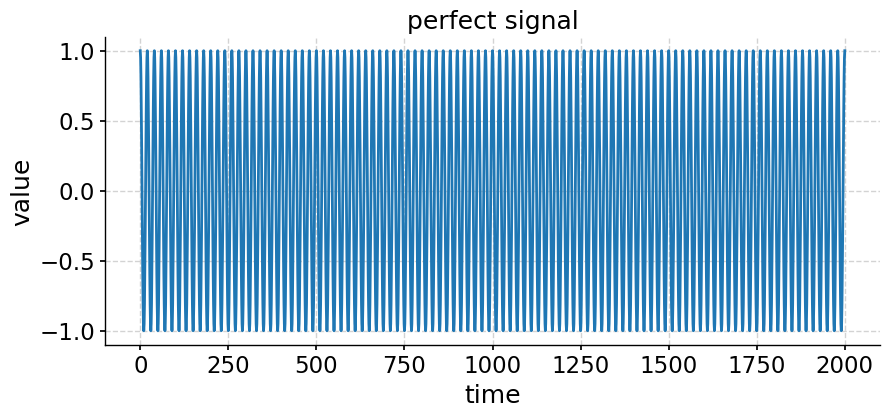

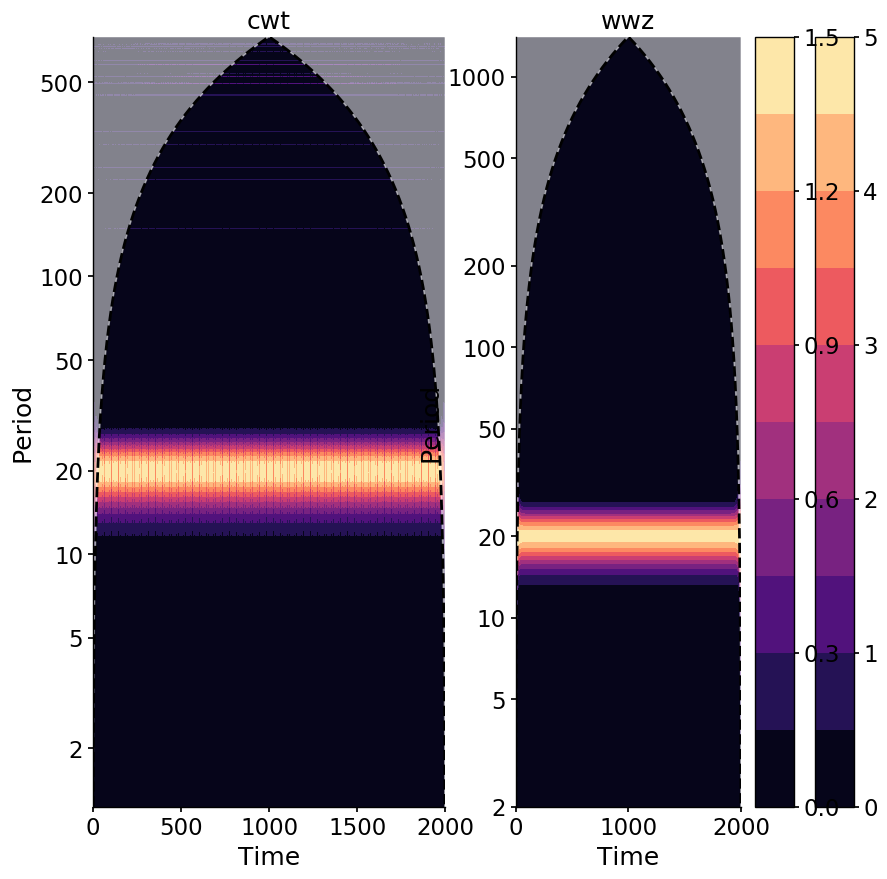

In [3]:
freq=1/20
time=np.arange(2001)
signal=np.cos(2*np.pi*freq*time)

ts=pyleoclim.Series(time=time,value=signal)
fig=ts.plot(title='perfect signal')
plt.show()
fig1,ax=compare_method(ts)
plt.show()

## two mixed constant frequencies signal

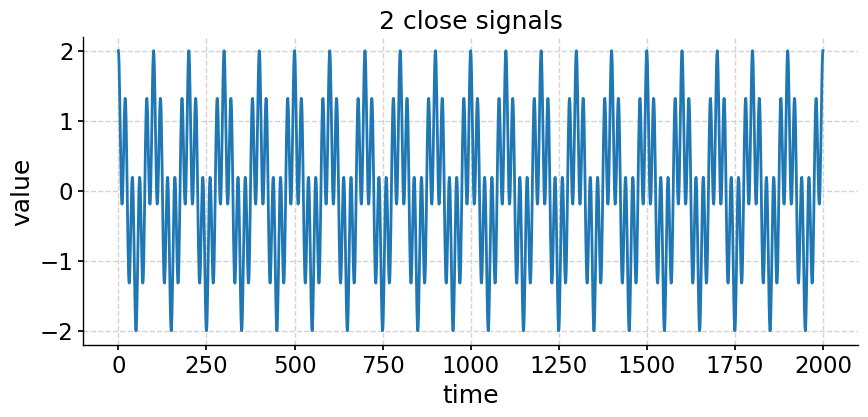

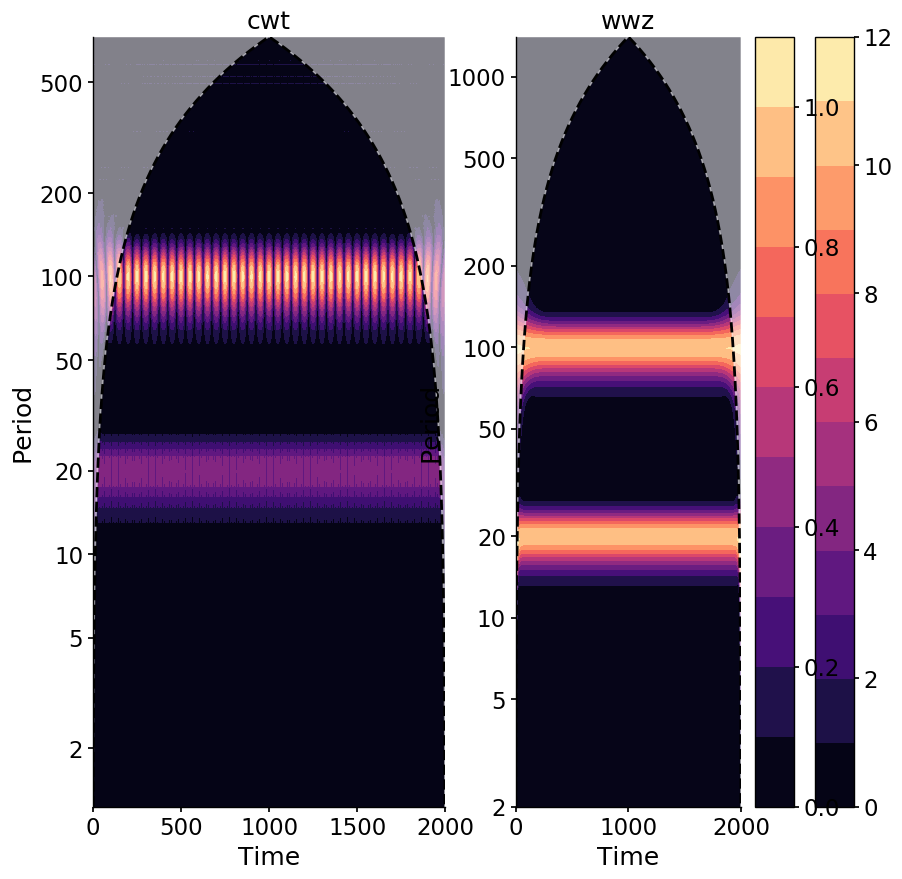

In [4]:
freq1=1/20
freq2=1/100
signal=np.cos(2*np.pi*freq1*time)+np.cos(2*np.pi*freq2*time)
ts=pyleoclim.Series(time=time,value=signal)
fig=ts.plot(title='2 close signals')
plt.show()
fig1,ax=compare_method(ts)
plt.show()

## Colored Noise

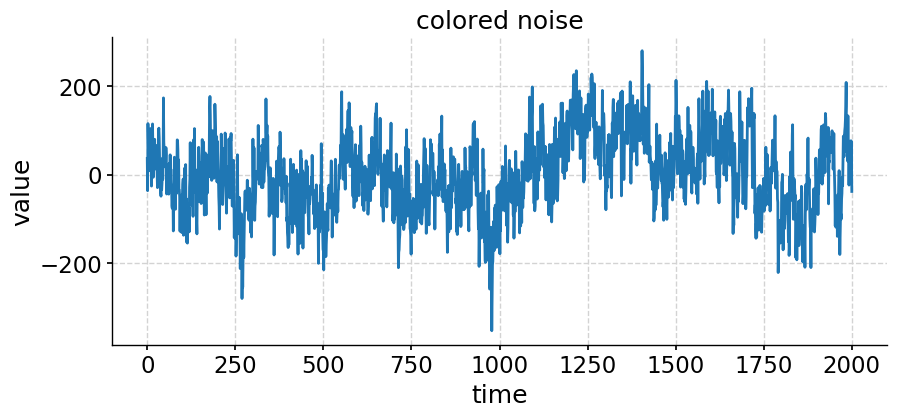

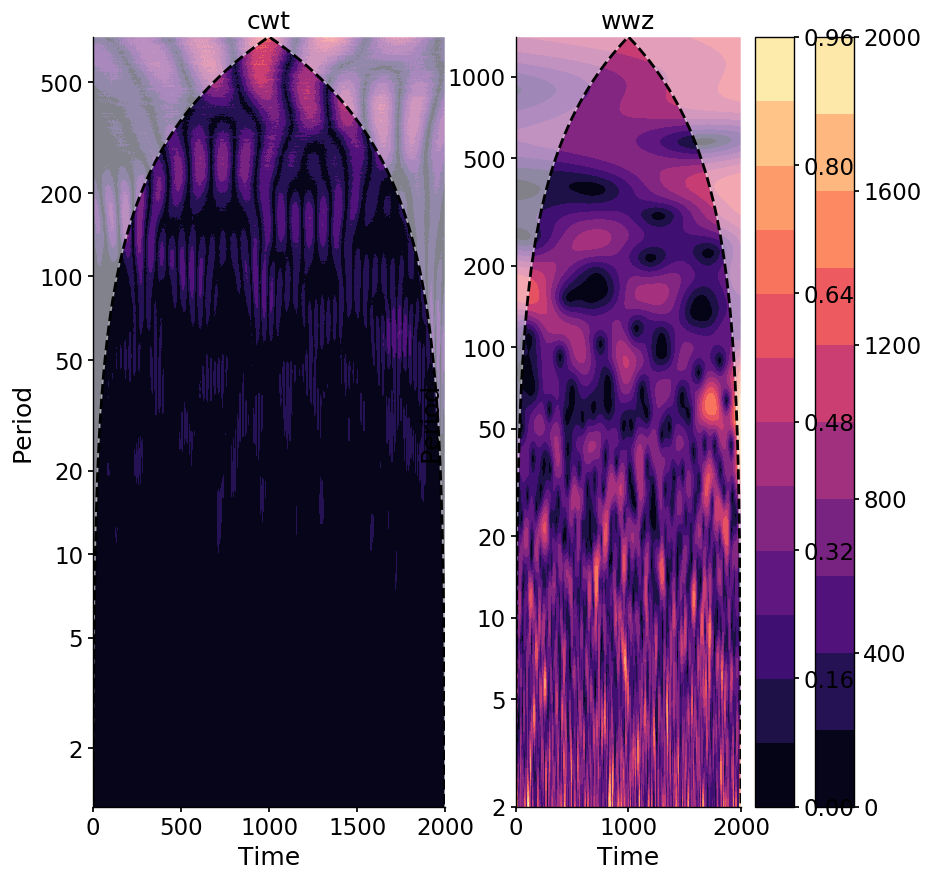

In [5]:
signal=colored_noise(1,time,seed=2333)
ts=pyleoclim.Series(time=time,value=signal)
ffig=ts.plot(title='colored noise')
plt.show()
fig1,ax=compare_method(ts)
plt.show()

## Colored Noise with 2 regimes

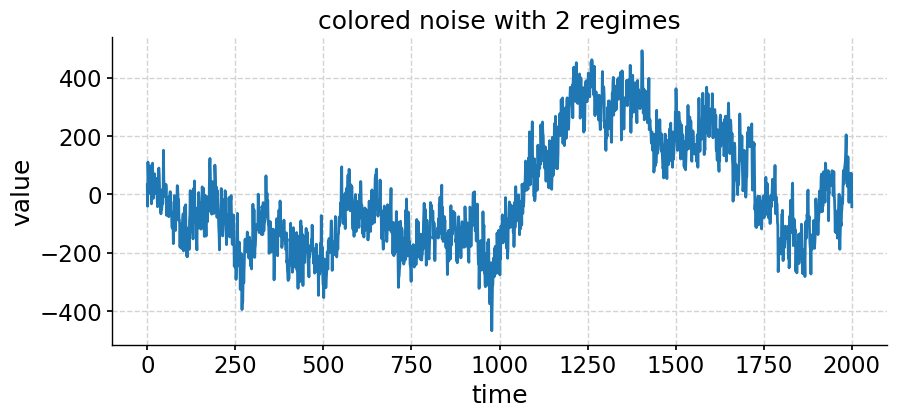

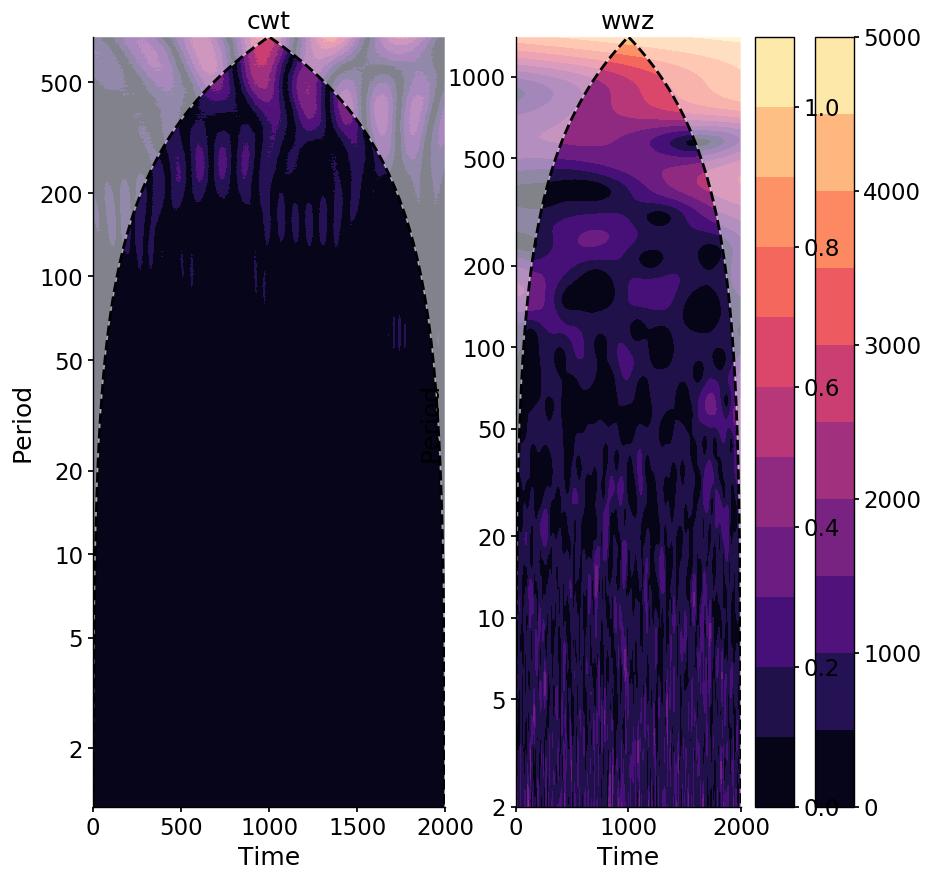

In [6]:
signal=colored_noise_2regimes(1,2,1/100,time,seed=2333)
ts=pyleoclim.Series(time=time,value=signal)
ffig=ts.plot(title='colored noise with 2 regimes')
plt.show()
fig1,ax=compare_method(ts)
plt.show()

## White Noise

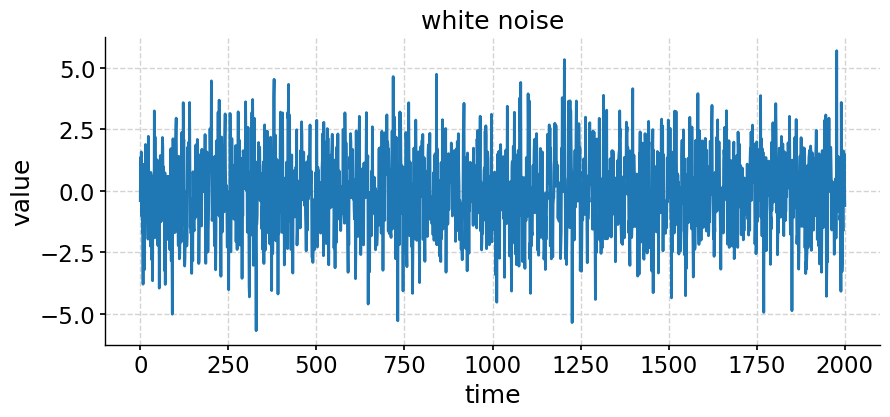

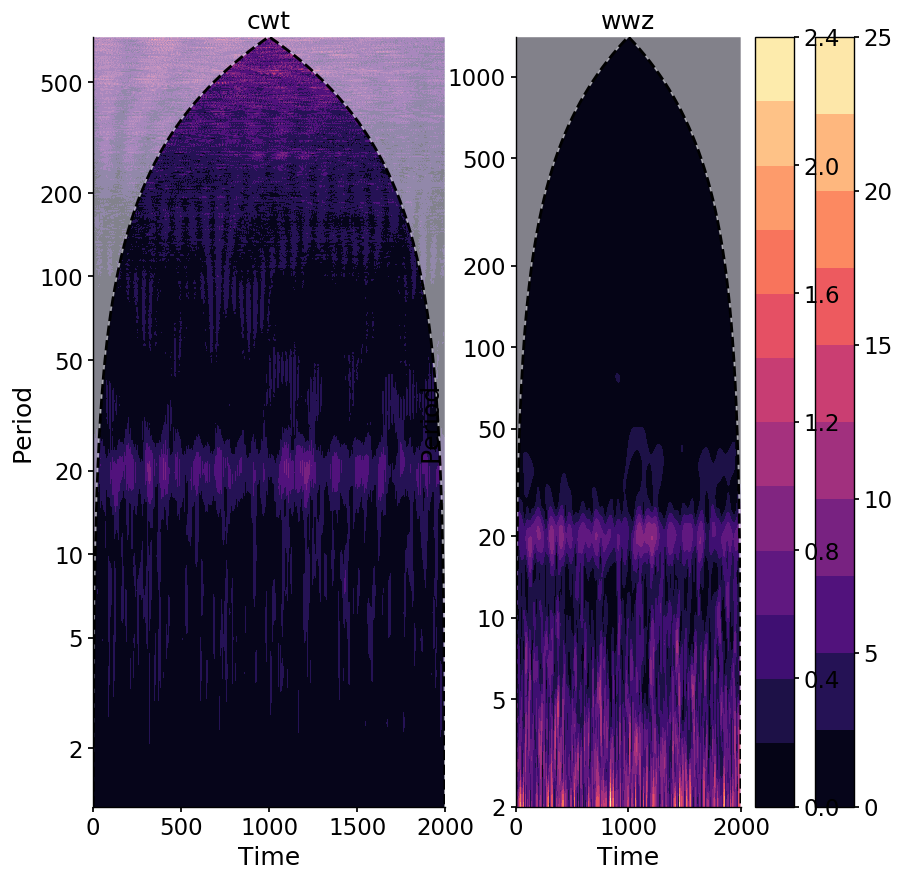

In [7]:
snr=0.25
signal=np.cos(2*np.pi*freq*time)
sig_var=np.var(signal)
noise_var=sig_var/snr
white_noise=np.random.normal(0,np.sqrt(noise_var),size=np.size(signal))
signal+=white_noise
ts=pyleoclim.Series(time=time,value=signal)
fig=ts.plot(title='white noise')
plt.show()
fig1,ax=compare_method(ts)
plt.show()

## Signal with linear trend

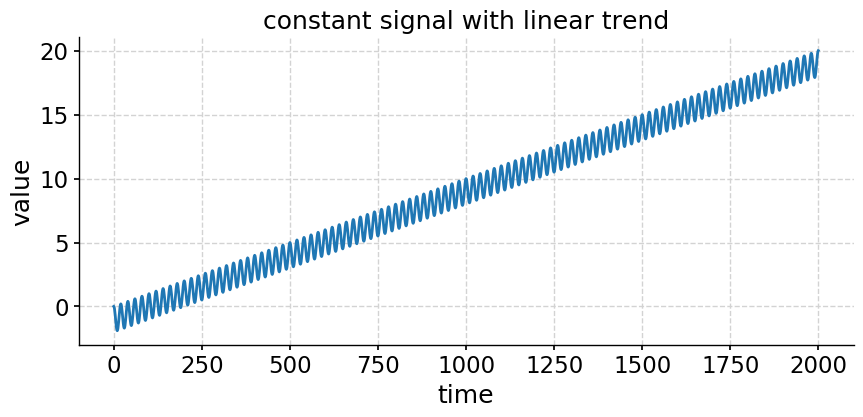

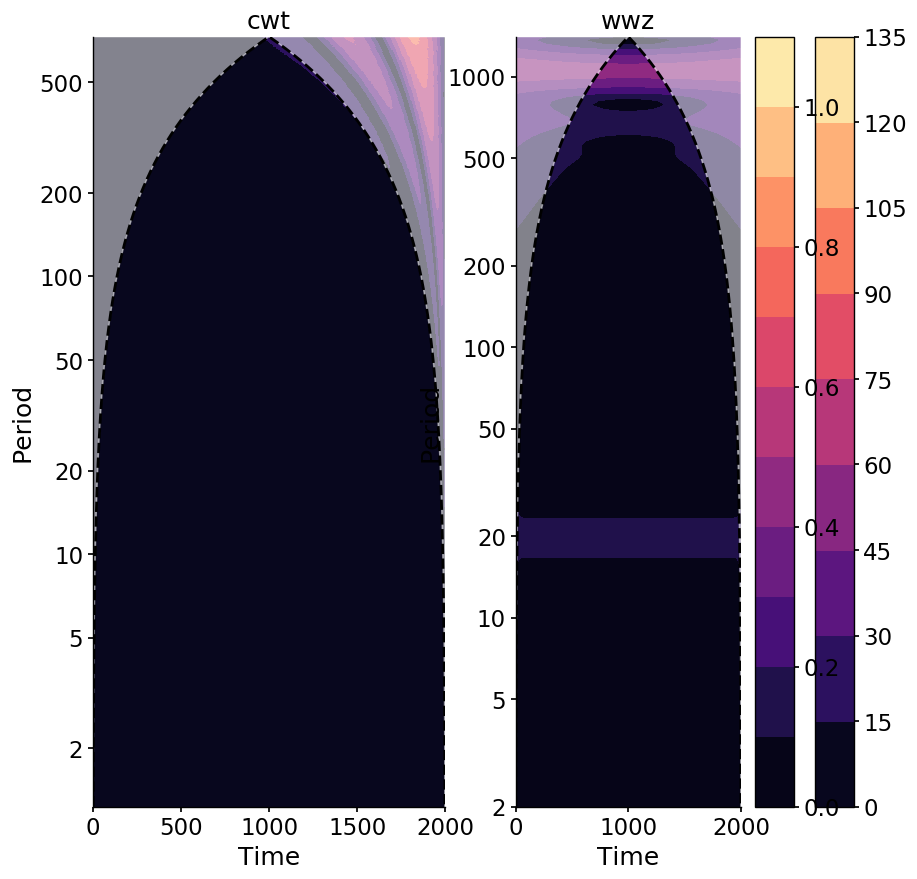

In [8]:
slope=0.01
intercept=-1
linear_trend=slope*time+intercept
freq=1/20

signal=np.cos(2*np.pi*freq*time)
signal+=linear_trend
ts=pyleoclim.Series(time=time,value=signal)
fig=ts.plot(title='constant signal with linear trend')
plt.show()
fig1,ax=compare_method(ts)
plt.show()

## Signal with Nonlinear trend

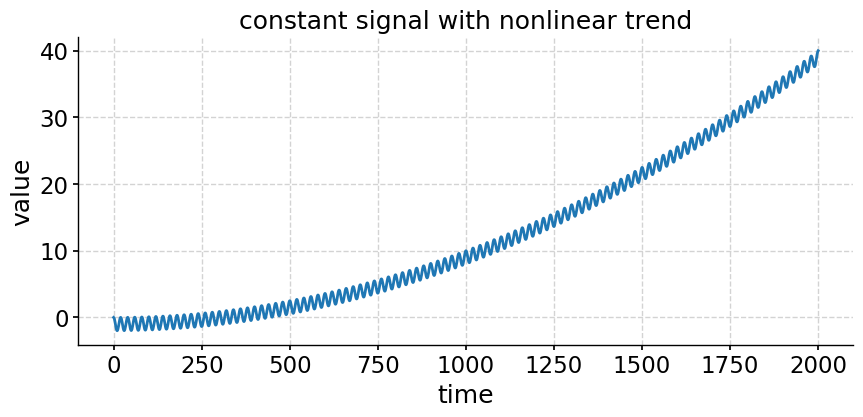

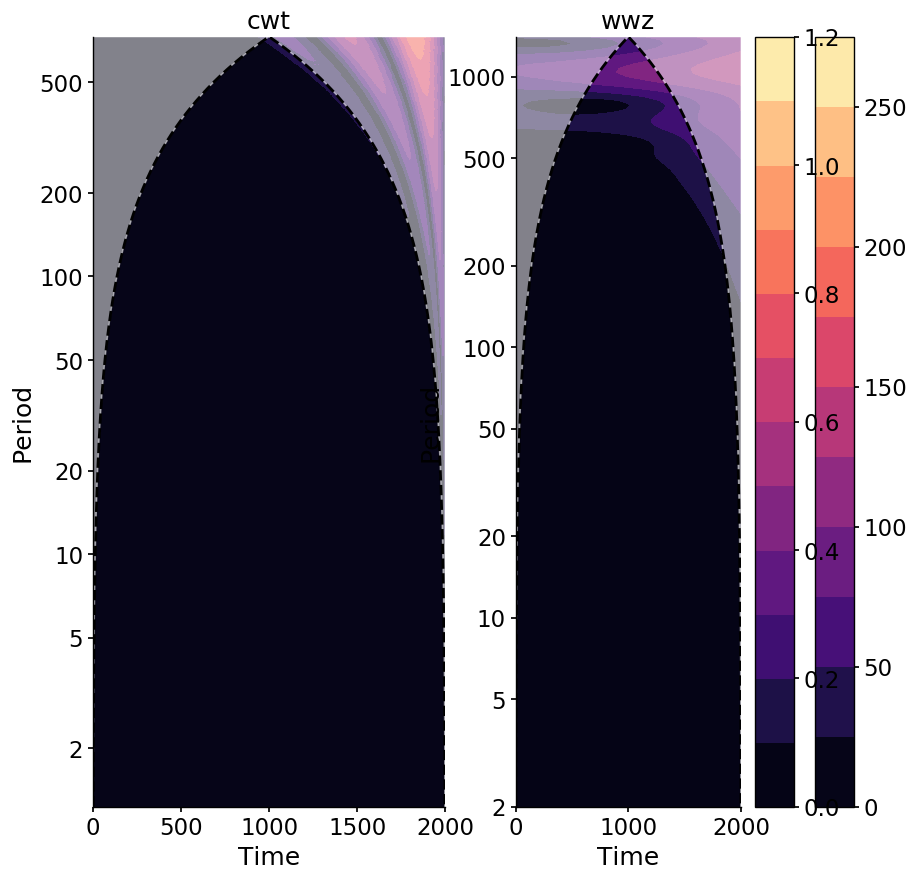

In [9]:
slope=1e-5
intercept=-1
nonlinear_trend=slope*time**2 + intercept
signal=np.cos(2*np.pi*freq*time)
signal+=nonlinear_trend
ts=pyleoclim.Series(time=time,value=signal)
fig=ts.plot(title='constant signal with nonlinear trend')
plt.show()
fig1,ax=compare_method(ts)
plt.show()

## Randomly deleted data points

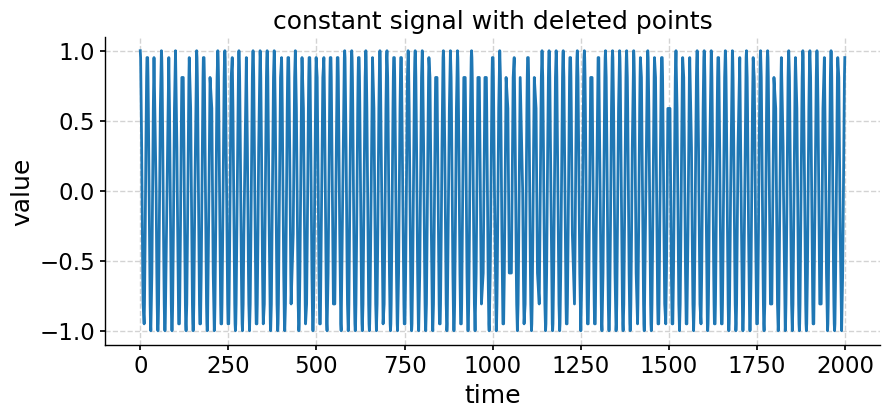

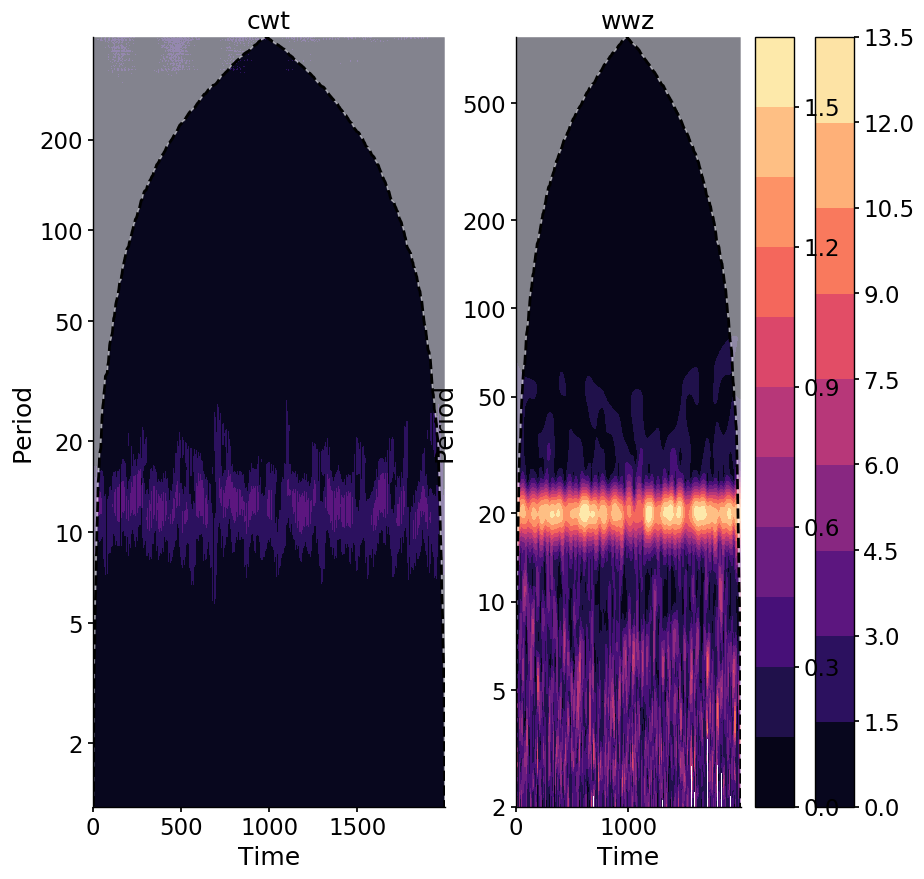

In [10]:
del_percent=0.4
freq=1/20
signal=np.cos(2*np.pi*freq*time)
n_del=int(del_percent*np.size(time))
deleted_idx=np.random.choice(range(np.size(time)),n_del,replace=False)
time_uneven=np.delete(time,deleted_idx)
signal_uneven=np.delete(signal,deleted_idx)

ts=pyleoclim.Series(time=time_uneven,value=signal_uneven)
fig=ts.plot(title='constant signal with deleted points')
plt.show()
fig1,ax=compare_method(ts)
plt.show()

## Deleted Gap

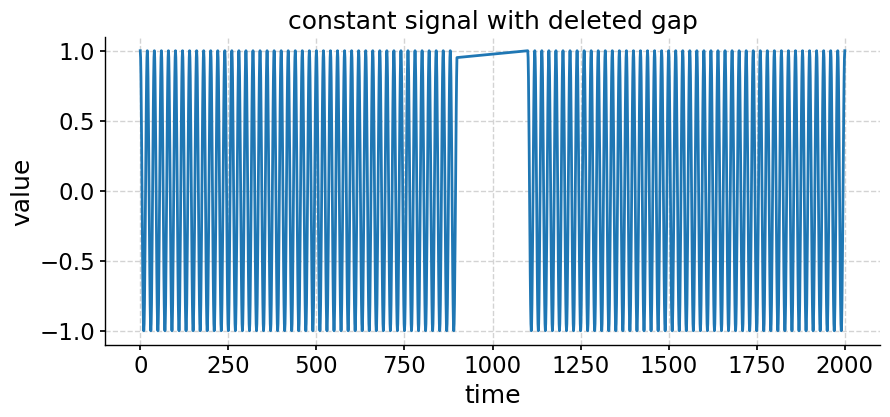

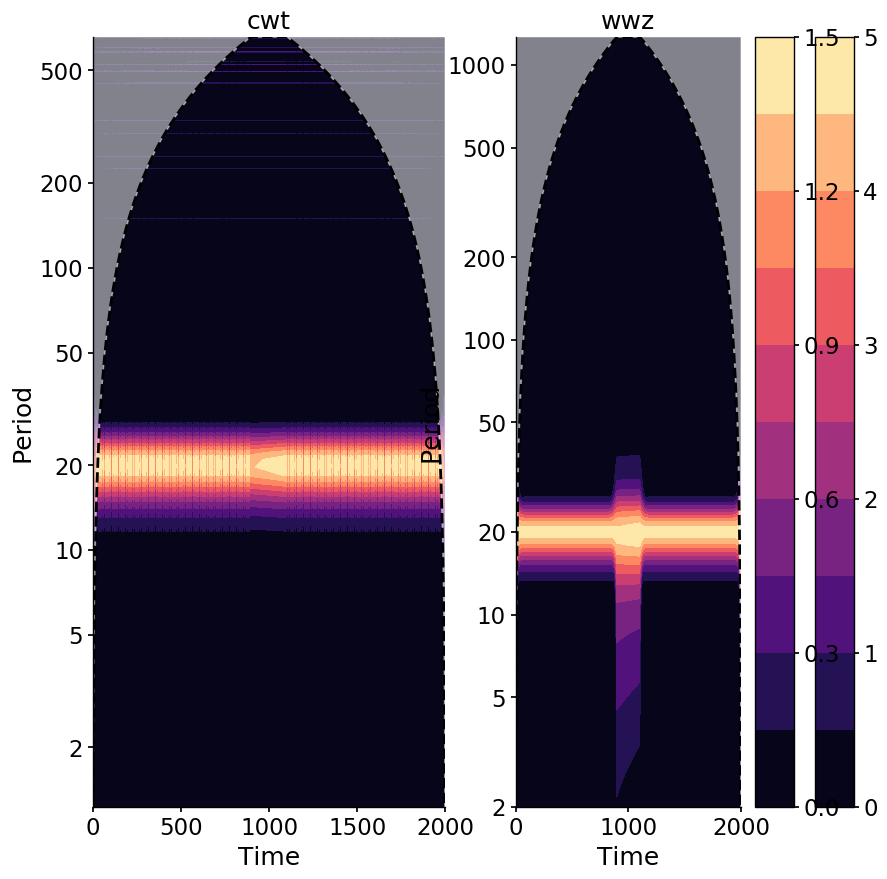

In [11]:
nt=np.size(time)
freq=1/20
gaplength=200
signal=np.cos(2*np.pi*freq*time)
deleted_idx=np.arange(nt//2-gaplength//2,nt//2+gaplength//2)
time_gap=np.delete(time,deleted_idx)
signal_gap=np.delete(signal,deleted_idx)

ts=pyleoclim.Series(time=time_gap,value=signal_gap)
fig=ts.plot(title='constant signal with deleted gap')
plt.show()
fig1,ax=compare_method(ts)
plt.show()